In [1]:
from pathlib import Path
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from powerlaw import plot_pdf, plot_cdf, plot_ccdf

from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
from src.eeg_analysis.analysis.criticality import NeuronalAvalanche
from src.eeg_analysis.visualization.plots import plot_eeg
from src.eeg_analysis.visualization.my_custom_style import set_custom_style

In [2]:
participant_id = 1
base_dir = Path(r'D:\Anesthesia_Research_Fellow') / f'CA-{participant_id:02}'
base_path = base_dir / f'CA-{participant_id:02}'

vhdr_path = base_path.with_suffix('.vhdr')
vmrk_path = base_path.with_suffix('.vmrk')
eeg_path = base_path.with_suffix('.eeg')

eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
eeg_file.load_data()

EEG Data Shape: (10477791, 21)


In [3]:
preprocessor = EEGPreprocessor(eeg_file)

# target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    # ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
    ('exclude_noisy_periods', {'window_size':2, 'threshold':10, 'min_num_channels':1, 'padding':'zeros'})
]
preprocessor.process(sequence_of_operations)

In [4]:
na = NeuronalAvalanche(preprocessor)

In [5]:
na.calculate_segmented_eeg(segment_duration=300)

In [6]:
na.detect_avalanches(threshold=2, 
                    method='beggs', 
                    epoch_names=[
                        'preop_rest', 
                        # 'maintenance',
                        # 'pre_drug_infusion', 
                        'emergence', 
                        'pacu_rest'
                        ],
                    inter_event_interval=12, # in ms
                    bin_size=2, # in ms
                    use_pearson_correlation=False,
                    event_boundary='zero_crossing')

D:\capachinos\src\eeg_analysis\utils\helpers.py:101: RuntimeWarning: invalid value encountered in divide
  initial_z_score = (segment_eeg - np.mean(segment_eeg)) / np.std(segment_eeg)


C:\Users\Kourosh\AppData\Local\Temp\ipykernel_16220\2477367924.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap(colormap, N)


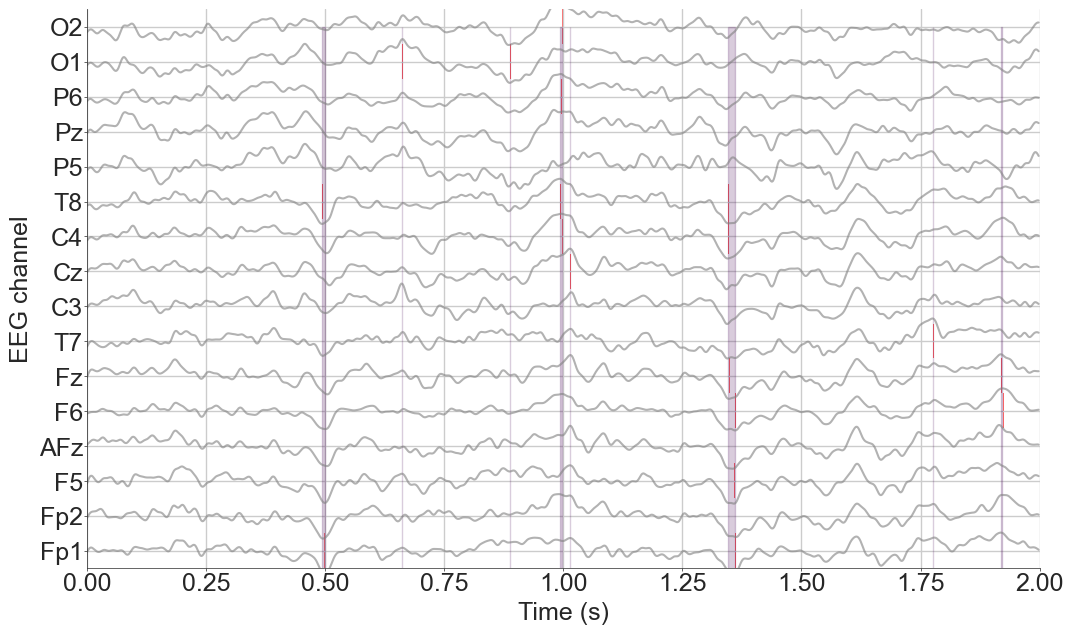

In [ ]:
def generate_colors(N, colormap='viridis'):
    return cm.get_cmap(colormap, N)

def plot_eeg(eeg, sample_rate, ax, start_time_offset=0, channel_labels=None):
    """
    Plot EEG data with each channel on a separate row in a single Axes.
    """
    n_samples, n_channels = eeg.shape
    time = np.arange(0, n_samples) / sample_rate + start_time_offset

    if channel_labels is None:
        channel_labels = [f'Channel {i+1}' for i in range(n_channels)]

    for i in range(n_channels):
        current_eeg = eeg[:, i]
        max_amplitude = np.max(np.abs(current_eeg))
        normalized_eeg = current_eeg * (0.65 / max_amplitude)
        ax.plot(time, normalized_eeg+i, label=channel_labels[i], color='gray', alpha=0.6)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('EEG channel')
    ax.set_yticks(range(n_channels))
    ax.set_yticklabels(channel_labels)
    ax.grid(True)

    plt.tight_layout()

# Initialize parameters
channel_labels = na.channel_names[:16]
sample_rate = na.sampling_frequency
threshold = na.detection_params.threshold
epoch_name = 'emergence'
duration = 2*sample_rate
seg_idx = 0
digitized_signal = na.avalanches[epoch_name][seg_idx]['digitized_signal'].T
avalanche_times = na.avalanches[epoch_name][seg_idx]['avalanche_times']
z_scored_eeg = na.avalanches[epoch_name][seg_idx]['z_scored_eeg']

# Set figure styles
set_custom_style()

fig, ax = plt.subplots(figsize=(10, 6))

# Prepare the time array for EEG
n_samples = z_scored_eeg[:duration, :].shape[0]
time = np.arange(0, n_samples+1) / sample_rate

# Plot the continuous EEG signal
plot_eeg(z_scored_eeg[:duration, :], sample_rate, ax, start_time_offset=0, channel_labels=channel_labels)

# Overlay the digitized signal using extent to align with EEG time and channels

# Create a custom colormap for the digitized signal
cmap = mcolors.ListedColormap(['none', 'red']) # 'none' makes 0 fully transparent, 'blue' for 1 fully opaque
bounds = [-0.5, 0.5, 1.5]  # Define bounds for 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax.imshow(digitized_signal[:, :duration], aspect='auto', interpolation='None', alpha=0.6, extent=[time[0], time[-1], -0.5, z_scored_eeg.shape[1]-0.5], cmap=cmap, norm=norm, origin='lower')

# Overlay rectangles for start and end times of avalanches
num_avalanches = len(avalanche_times)
colors = generate_colors(num_avalanches)

for i, (start, end) in enumerate(avalanche_times):
    rel_start = start - (seg_idx*na.segment_duration*sample_rate)
    rel_end = end - (seg_idx*na.segment_duration*sample_rate)
    if rel_start < duration or rel_end < duration:  # Ensuring that we don't plot rectangles outside the range of the imshow
        color = colors(i)
        ax.axvspan(rel_start / sample_rate, rel_end / sample_rate, ymin=(0 - 0.5) / z_scored_eeg.shape[1], ymax=(z_scored_eeg.shape[1] - 0.5) / z_scored_eeg.shape[1], facecolor=color, edgecolor=color, alpha=0.2)

ax.tick_params(axis='both', which='major', labelsize=18, length=2, width=0.5, pad=1)
yl = ax.get_ylabel()
ax.set_ylabel(yl, fontsize=18)

xl = ax.get_xlabel()
ax.set_xlabel(xl, fontsize=18)

main_dir = f'D:/capachinos' 
filename = 'avalanches.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Avalanche start and end times and the time of the events within each avalanche relative to the start of the avalanche 

In [ ]:
segment_idx = 0
na.avalanches['emergence'][segment_idx]['avalanche_times'][:10] # tuples containing to start and end times of 10 first avalanches from, calculated from an eeg segment

[(247, 250),
 (331, 331),
 (444, 444),
 (496, 499),
 (507, 507),
 (673, 680),
 (888, 888),
 (959, 961),
 (1054, 1054),
 (1085, 1085)]

In [ ]:
segment_idx = 0
event_details = na.avalanches['emergence'][0]['event_details'][6] # timings of the events in one example avalanche relative to the start of the avalanche
print(event_details)

{6: [(0, 2.1276512)]}


#### Calculate the correlogram of the events from on channel versus the events detected on other channels. 
##### This might be useful for calculating an optimal inter-event-interval for detecting avalanches 

In [ ]:
na.calculate_event_correlograms(max_lag=0.2)

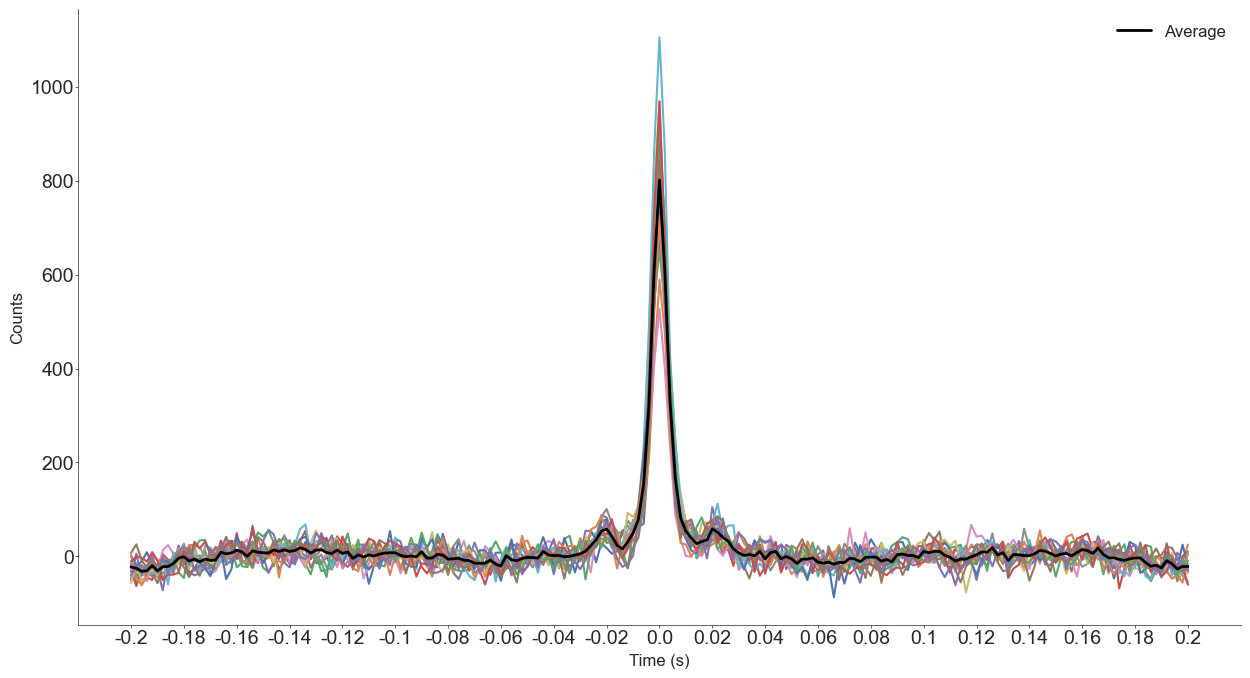

In [ ]:
correlograms = na.event_correlograms['emergence']
values = correlograms['correlogram']
lags = correlograms['lags']

# Define the baseline based on lags > 50 or lags < -50
baseline_mask = (lags > 10) | (lags < -10)
baseline_values = np.mean(values[:, baseline_mask], axis=1)

# Subtract the baseline from each correlogram
values_baseline_corrected = values - baseline_values[:, np.newaxis]

# Plot each baseline-corrected correlogram
set_custom_style()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(values_baseline_corrected.T)

# Set x-ticks and x-tick labels
ax.set_xticks(np.arange(0, len(lags), 10))
ax.set_xticklabels(np.arange(min(lags), max(lags)+1, 10)/na.sampling_frequency)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

# Calculate and plot the average of the baseline-corrected values
average_values = np.mean(values_baseline_corrected, axis=0)
ax.plot(average_values, color='black', linewidth=2, label='Average')

# Optional: Add legend
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=14, length=2, width=0.5, pad=1)


plt.show()

In [ ]:
na.mean_interevent_intervals

{'preop_rest': 0.020930282064928155,
 'emergence': 0.006019614728604395,
 'pacu_rest': 0.007276363299694474}

In [ ]:
na.calculate_avalanche_params(region_wise=False)

preop_rest
emergence
pacu_rest


#### Plot the distribution of avalanche params over time, inculding:<br>
**duration**, <br>
**sum_z**: summation of peak values of the belonging events,<br>
**chan_count** :number of channels with detected events during the avalanche, and <br>
**region_count**: number of active regions 

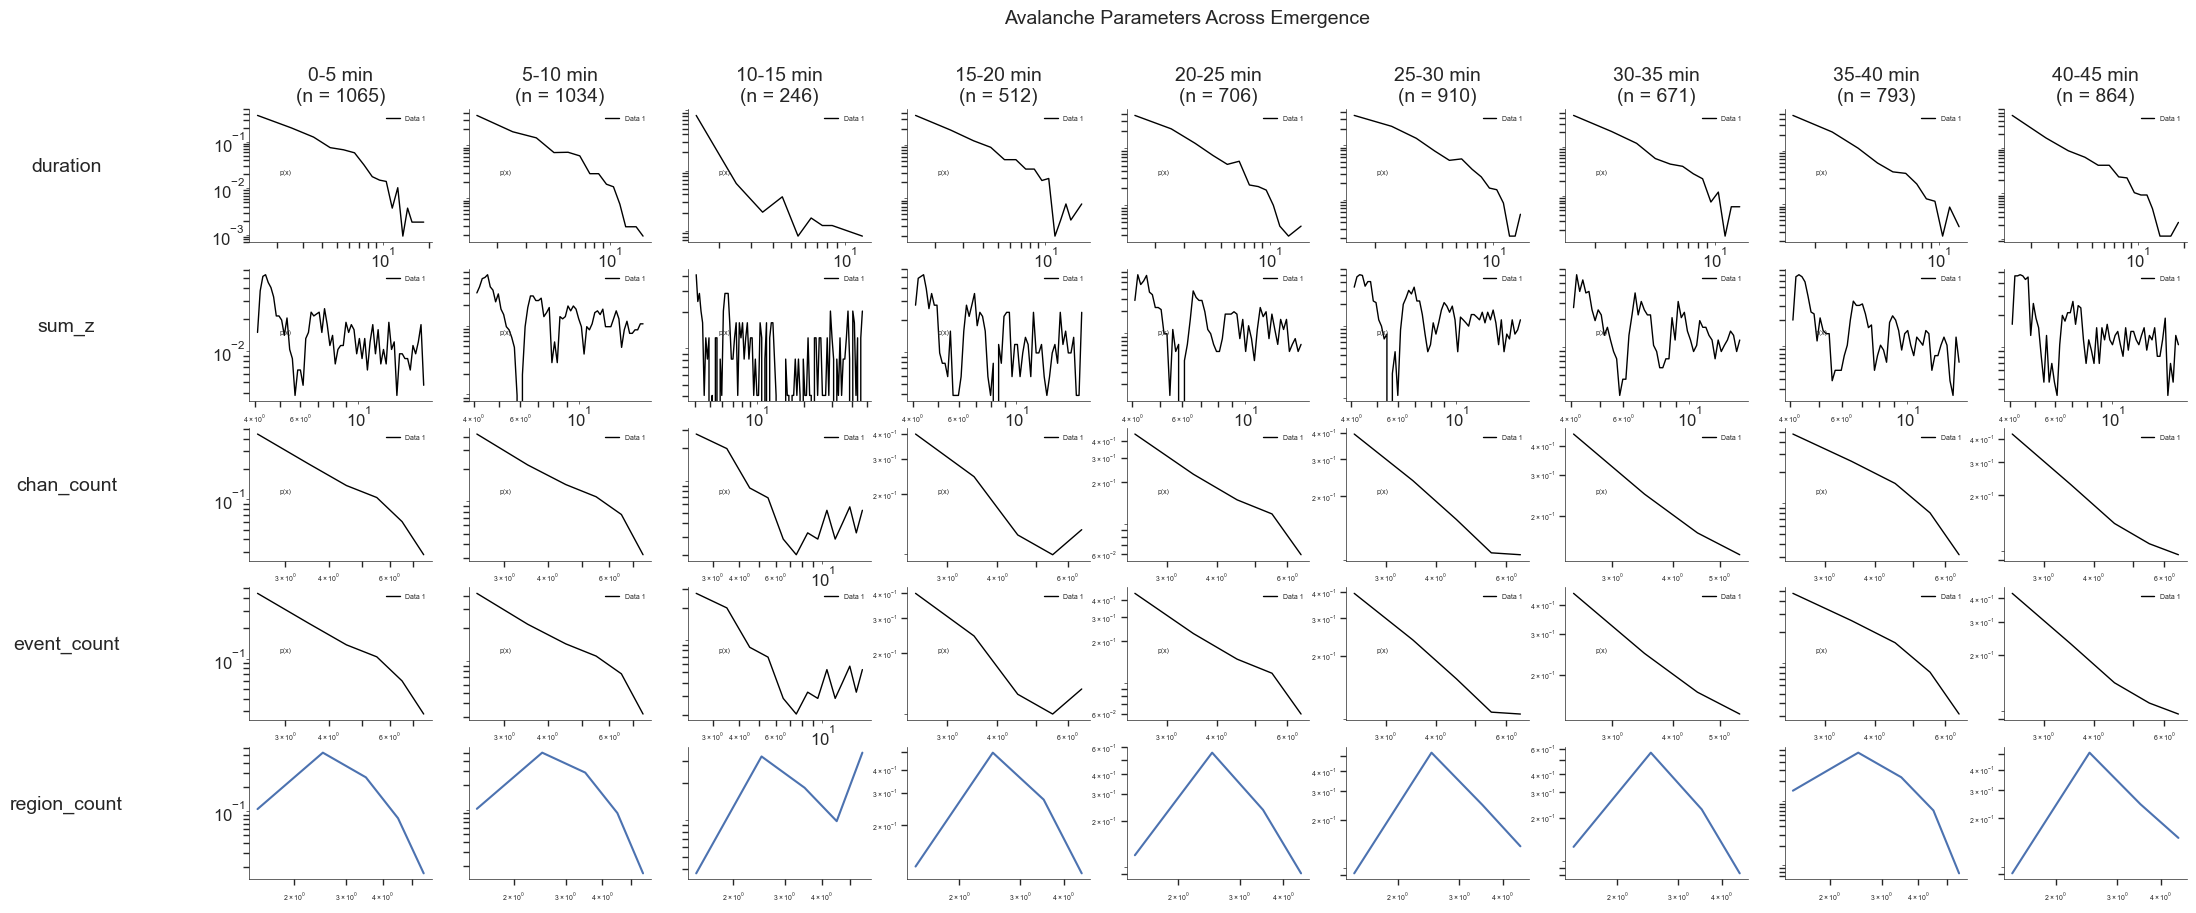

In [ ]:
from src.eeg_analysis.utils.NCC_converted_toolbox import plplottool

# Set figure styles
set_custom_style()

epoch_name = 'emergence'
params = ['duration', 'sum_z', 'chan_count', 'event_count', 'region_count']  #
segment_duration = int(na.segment_duration/60) # in minutes


log_y_axis = {
    'duration': True,
    'sum_raw': True,
    'sum_z': True,
    'chan_count': True,
    'event_count': True,
    'region_count': False
}  # Flag to toggle log or linear y-axis

# Set up the figure and GridSpec layout
fig_width, fig_height = 25, 10
fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])
num_params = len(params)

num_segments = len(na.avalanche_params[epoch_name])

# Define GridSpec: each parameter gets its own column
gs = GridSpec(nrows=num_params, ncols=num_segments, figure=fig, wspace=0.2, hspace=0.2)
# Use a colormap to differentiate epochs
# colors = plt.cm.viridis(np.linspace(0, 1, len(epochs)))

# Loop over parameters and plot data
for param_idx, param in enumerate(params):

    epoch_start_indices = []

    segment_data = [na.avalanche_params[epoch_name][seg_idx].get(param) for seg_idx in range(num_segments)]

    for seg_idx, segment in enumerate(segment_data):
        segment_start = seg_idx*segment_duration
        segment_end = segment_start + segment_duration

        ax = fig.add_subplot(gs[param_idx, seg_idx])  # Use GridSpec for positioning
        if segment is None or len(segment) == 0:
            continue
        
        num_avalanches_in_segment = len(segment)
        # try:
        # fit = powerlaw.Fit(segment, xmin=xmin, verbose=False)
        if log_y_axis[param]:
            # fit.plot_pdf(ax=ax, original_data=True) #
            plplottool(np.array(segment), 'binDensity', 100, 'ax', ax)
            # plot_pdf(segment, ax=ax)
            # plot_ccdf(segment, ax=ax)
        else:
            # fit.plot_pdf(ax=ax, linear_bins=True, original_data=True)
            plot_pdf(segment, ax=ax, linear_bins=True)
            # plot_ccdf(segment, ax=ax)

        # except:
        #     print(f'did not work for segment {i} of param={param}')

        if log_y_axis[param]:
            ax.set_xscale('log')

        if seg_idx > 0:
            ax.set_yticklabels([])

        # ax.set_xlim(data_range)

        ax.tick_params(axis='both', which='major', labelsize=12, length=2, width=0.5, pad=1)
        ax.yaxis.label.set_rotation(0) 
        ax.yaxis.set_label_coords(-1,0.5)

        if seg_idx==0:
            ax.set_ylabel(param, fontsize=14)
        if param_idx==0:
            ax.set_title(f'{segment_start}-{segment_end} min\n(n = {num_avalanches_in_segment})', fontsize=14)

fig.suptitle('Avalanche Parameters Across Emergence', fontsize=14)
# fig.tight_layout()
plt.show()

##### Explore the loss functions represented by $D$,  $\sigma$ (standard deviation of PL exponent $\alpha$), and $R_{\exp}$ as a function of $x_{min}$ and $x_{max}$ for calculating power-law fits

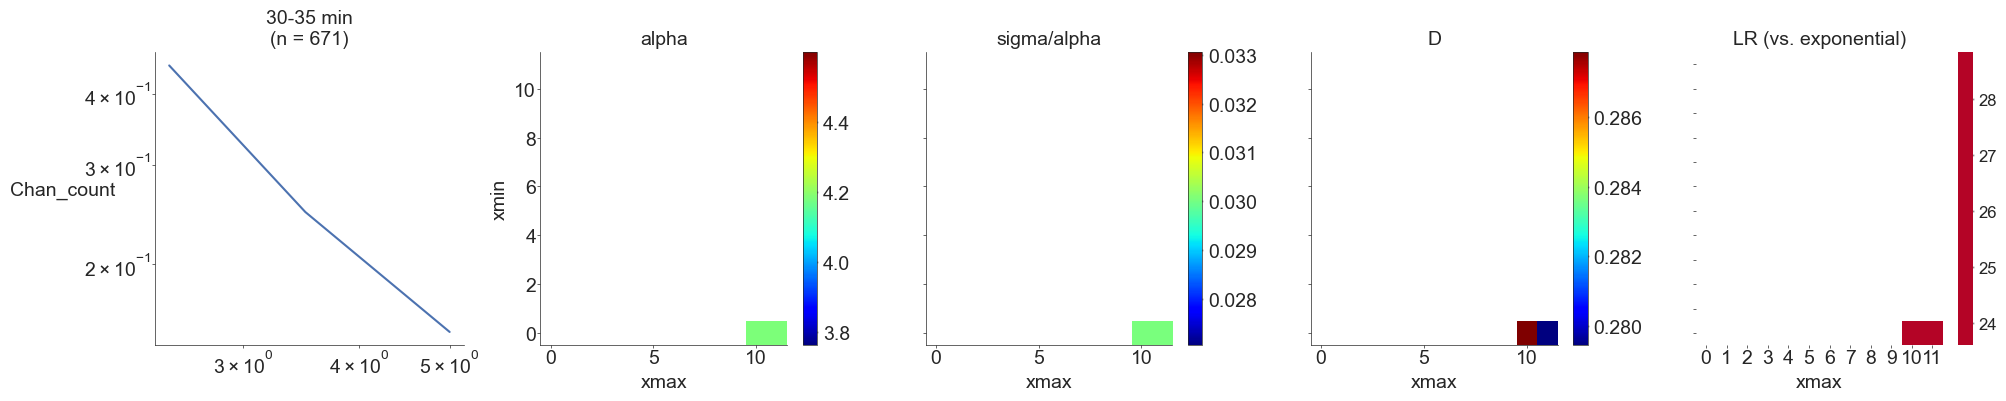

In [ ]:
import seaborn as sns

# Set figure styles
set_custom_style()

# Sample data, assuming `fit` and `na` are already defined as in your context
epoch_name = 'emergence'
param = 'chan_count'
seg_idx = 6

segment_duration = int(na.segment_duration/60) # in minutes
segment_start = seg_idx*segment_duration
segment_end = segment_start + segment_duration

data = na.avalanche_params[epoch_name][seg_idx].get(param)
num_avalanches_in_segment = len(data)

fit = na.avalanche_params[epoch_name][seg_idx].power_law_fits[param]

alpha_2d = fit.alpha_2d
D_2d = fit.D_2d
sigma_2d = fit.sigma_2d
R_exp_2d = fit.R_exp_2d

xmins_set = sorted(set(fit.xmins))
xmaxs_set = sorted(set(fit.xmaxs))

# Apply logarithmic transformation to sigma_2d (using log10)
sigma_2d_log = np.log10(np.clip(sigma_2d, 1e-10, None))

# Define the figure and subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

def plot_heatmap(ax, data, title, show_ylabel=False, diverging_cmap=False):

    if diverging_cmap:
        
        im = sns.heatmap(data, cmap="coolwarm", center=0)
        ax.invert_yaxis()  
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)
        
    else:
        im = ax.imshow(data, origin='lower', aspect='auto', cmap='jet')
        # Add a colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=14)
        
    # ax.set_xticks(np.arange(len(xmaxs_set)))
    # ax.set_xticklabels([f"{x:.4f}" for x in xmaxs_set], rotation=45)
    ax.set_xlabel('xmax', fontsize=14)
    
    # ax.set_yticks(np.arange(len(xmins_set)))
    if show_ylabel:
        # ax.set_yticklabels([f"{x:.4f}" for x in xmins_set])
        ax.set_ylabel('xmin', fontsize=14)
    else:
        ax.set_yticklabels([])

    ax.tick_params(axis='both', which='major', labelsize=14, length=2, width=0.5, pad=1)
    ax.set_title(title, fontsize=14)


# Prepare custom colorbar ticks and labels for sigma
sigma_ticks = np.logspace(np.log10(1e-10), np.log10(np.max(sigma_2d)), num=10)

# Create subplots
curr_ax = axs[0]
plot_pdf(data, ax=curr_ax)
curr_ax.set_xscale('log')
curr_ax.set_ylabel(param.capitalize(), fontsize=14)
curr_ax.yaxis.label.set_rotation(0) 
curr_ax.yaxis.set_label_coords(-0.3,0.5)
curr_ax.set_title(f'{segment_start}-{segment_end} min\n(n = {num_avalanches_in_segment})', fontsize=14)
curr_ax.tick_params(axis='both', which='both', labelsize=14, length=2, width=0.5, pad=1)


plot_heatmap(axs[1], alpha_2d, 'alpha', show_ylabel=True)
plot_heatmap(axs[2], np.divide(sigma_2d, alpha_2d), 'sigma/alpha')
plot_heatmap(axs[3], D_2d, 'D')
plot_heatmap(axs[4], R_exp_2d, 'LR (vs. exponential)', diverging_cmap=True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

##### Investigate minimum and maximum avalanche parameter values for each segment

In [ ]:
all_segments_av_param_values = [na.avalanche_params['emergence'][seg_idx].duration for seg_idx in range(len(na.avalanche_params['emergence']))] 
all_segments_av_param_values = np.concatenate(all_segments_av_param_values).tolist()

aa = set(all_segments_av_param_values)
aa = [d for d in aa if d > 0]
print(min(aa), max(aa))

1.0 20.0


##### Plot the power-law distributions of avalanche size and duration for differnet segments in emergence epoch

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from powerlaw import plot_pdf, plot_ccdf
import numpy as np
import math

def plot_power_law_fit(ax, alpha, xmin, xmax, y_start, color='red', label='Power Law Fit'):
    """Helper function to plot the power law fit on the ax within xmin to xmax range starting at y_start."""
    fit_line_x = np.linspace(xmin, xmax, num=100)
    fit_line_y = y_start * (fit_line_x / xmin) ** (-alpha)
    
    # Adding the fitted line to the plot
    ax.plot(fit_line_x, fit_line_y, color=color, linestyle='--', label=label)

# Assuming set_custom_style() is a user-defined function to set the plotting style
# set_custom_style()

# Retrieve number of segments
num_segments = len(na.avalanche_params['emergence'])

# Calculate number of columns and rows needed
ncols = math.ceil(math.sqrt(num_segments))
nrows = math.ceil(num_segments / ncols)

# Calculate an approximate figure size
fig_width = 12  # inches
fig_height = 12  # inches (additional space for region titles)

# Create a figure
fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])

# Create a GridSpec layout
gs = GridSpec(
    nrows=nrows,
    ncols=ncols,
    figure=fig,
    wspace=0.2,
    hspace=0.2
)

# Plot each segment
for seg_idx in range(num_segments):
    try:
        ax = fig.add_subplot(gs[seg_idx])
        segment_data = na.avalanche_params['emergence'][seg_idx].chan_count
        segment_data = np.array(segment_data)
        segment_data = segment_data[segment_data > 0]

        # Retrieve power law fit parameters
        power_law_fit = na.avalanche_params['emergence'][seg_idx].power_law_fits['chan_count']
        alpha = power_law_fit.alpha
        xmin = power_law_fit.xmin
        xmax = power_law_fit.xmax
        print(xmin)
        # Plot PDF
        plot_pdf(segment_data, ax=ax, linear_bins=False)
        
        # Extract x and y data from the Axes
        line = ax.get_lines()[0]
        line_x_data = line.get_xdata()
        line_y_data = line.get_ydata()

        # Find the starting y-value in the desired range
        within_range_idx = (line_x_data >= xmin) & (line_x_data <= xmax)
        if np.any(within_range_idx):  # Check if there are points within the range
            y_start = line_y_data[within_range_idx][0]

            # Plot power law fit within the same x and y range
            plot_power_law_fit(ax, alpha, xmin, xmax, y_start)

        # Set titles and labels if needed
        ax.set_title(f'Segment {seg_idx}')
        ax.set_xlabel('Duration')
        ax.set_ylabel('Density')
    except:
        print('didnt work') 
# Adjust subplot parameters to ensure spacing
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.9)

# Show the plot
plt.show()

alpha_0: 2.5657553505304787 and alpha_1:12.475247433091978


<Axes: >

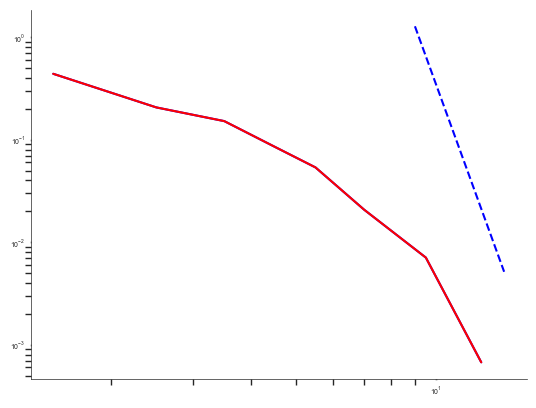

In [ ]:
import powerlaw

seg_idx = 1

av_durations = na.avalanche_params['emergence'][seg_idx].duration
av_durations = np.array(av_durations)
av_durations = av_durations[av_durations > 0]

power_law_fit = na.avalanche_params['emergence'][seg_idx].power_law_fits['duration']
xmin = power_law_fit.xmin
xmax = power_law_fit.xmax
alpha_0 = power_law_fit.alpha

fit = powerlaw.Fit(av_durations, verbose=False) # , xmin=xmin, xmax = xmax
alpha_1 = fit.power_law.alpha
print(f'alpha_0: {alpha_0} and alpha_1:{alpha_1}')
# fit.power_law.alpha = alpha_0
# fit.power_law.xmin = xmin
# fit.power_law.xmax = xmax

fig, ax = plt.subplots(1,1)
fit.plot_pdf(ax=ax, original_data=True, color='blue')
fit.power_law.plot_pdf(ax=ax, linestyle='--', color='blue')
plot_pdf(av_durations, ax = ax, color='red')

In [ ]:
xmax

12.462472324355405

In [ ]:
seg_idx = 2
alphas = na.avalanche_params['emergence'][seg_idx].power_law_fits['duration'].xmins
print(alphas)

[0.0001, 0.0001668100537200059, 0.0001668100537200059, 0.0002782559402207126, 0.0002782559402207126, 0.00046415888336127773, 0.001291549665014884, 0.002154434690031882, 0.00046415888336127773, 0.000774263682681127, 0.000774263682681127, 0.001291549665014884, 0.002154434690031882, 0.003593813663804626, 0.003593813663804626, 0.005994842503189409, 0.005994842503189409, 0.01, 0.0001, 0.0001668100537200059, 0.0002782559402207126, 0.00046415888336127773, 0.0002782559402207126, 0.000774263682681127, 0.000774263682681127, 0.001291549665014884, 0.002154434690031882, 0.003593813663804626, 0.00046415888336127773, 0.001291549665014884, 0.002154434690031882, 0.003593813663804626, 0.005994842503189409, 0.01, 0.0001, 0.00046415888336127773, 0.0001668100537200059, 0.000774263682681127, 0.0002782559402207126, 0.00046415888336127773, 0.000774263682681127, 0.001291549665014884, 0.001291549665014884, 0.002154434690031882, 0.003593813663804626, 0.005994842503189409, 0.002154434690031882, 0.01, 0.0001, 0.00

##### Average values of avalanche parameters per segment


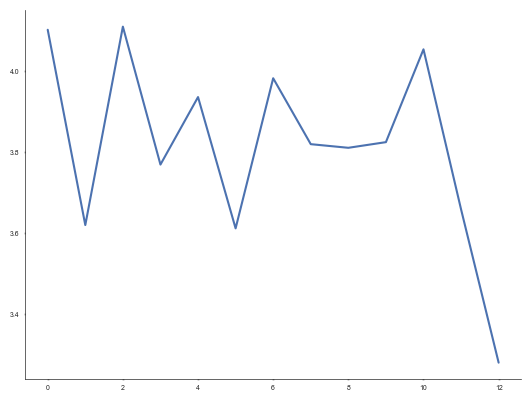

In [ ]:
segment_data = [na.avalanche_params['emergence'][seg_idx].avg_chan_count for seg_idx in range(len(na.avalanche_params['emergence']))]
plt.figure()
plt.plot(segment_data)
# plt.ylim([0, 20])

#### Plot power law fit results

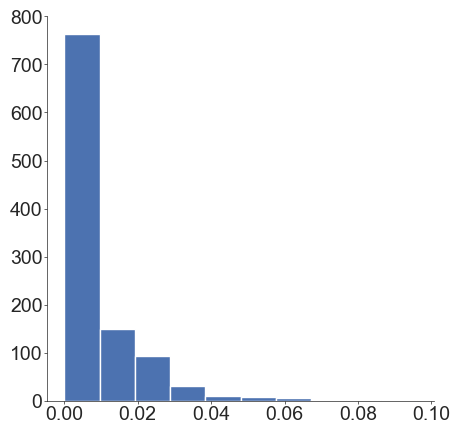

In [ ]:
duration = na.avalanche_params['emergence'][0].duration

fig, ax = plt.subplots(figsize =[5,5])
ax.hist(duration)
ax.tick_params(axis='both', which='major', labelsize=14, length=2, width=0.5, pad=1)

##### Using the NCC toolbox to estimate the power-law fits

tau: 2.289999999999999, xmin: 5.0, xmax: 14.0, sigmaTau: 0.19741010612428073, p-value: 0.44, critical p-value: 0.2, KS statistic: [0.04609084605254099, array([0.03273107, 0.0241127 , 0.0180329 , 0.06131573, 0.02794411,
       0.0410214 , 0.04939075, 0.01516988, 0.04294351, 0.01957477,
       0.0241127 , 0.08034594, 0.02640224, 0.05375368, 0.060885  ,
       0.05322217, 0.05571957, 0.0477287 , 0.02794411, 0.06885168,
       0.05476404, 0.06118885, 0.04596396, 0.05284193, 0.04982148,
       0.04326979, 0.01548146, 0.01548146, 0.06854784, 0.04225943,
       0.06141652, 0.03911209, 0.03751626, 0.06471642, 0.02300156,
       0.02723761, 0.03335857, 0.05634707, 0.06502027, 0.06502027,
       0.03106902, 0.04609085, 0.06172036, 0.03820034, 0.01452775,
       0.03873186, 0.03832723, 0.05735743, 0.04639469, 0.03820034,
       0.02761784, 0.0471012 , 0.04609085, 0.0693832 , 0.01904325,
       0.01917014, 0.06555178, 0.03873186, 0.04868424, 0.02028128,
       0.03406508, 0.0536268 , 0.02683297, 0

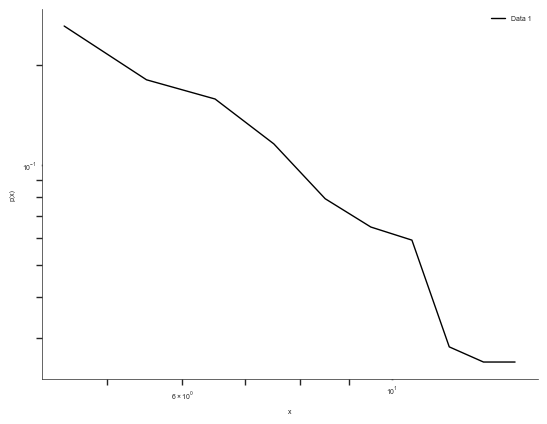

{'x': [(array([ 4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5]),
   array([0.26271186, 0.18079096, 0.15819209, 0.11581921, 0.07909605,
          0.06497175, 0.05932203, 0.02824859, 0.02542373, 0.02542373]))],
 'fit': []}

In [ ]:
from src.eeg_analysis.utils.NCC_converted_toolbox import plmle, plparams, plplottool

seg_idx = 6

duration = np.array(na.avalanche_params['emergence'][seg_idx].duration)
event_count = np.array(na.avalanche_params['emergence'][seg_idx].event_counts)
chan_count = np.array(na.avalanche_params['emergence'][seg_idx].chan_count)
sum_z = np.array(na.avalanche_params['emergence'][seg_idx].sum_z)

accepted_av_indices = np.where((event_count >= 4) & (duration > 0))[0]
duration = duration[accepted_av_indices]
event_count = event_count[accepted_av_indices]
chan_count = chan_count[accepted_av_indices]
sum_z = sum_z[accepted_av_indices]

num_samples = 100
tau, xmin, xmax, sigma, p, pCrit, ks = plparams(chan_count, 'samples', num_samples)
print(f'tau: {tau}, xmin: {xmin}, xmax: {xmax}, sigmaTau: {sigma}, p-value: {p}, critical p-value: {pCrit}, KS statistic: {ks}')
plplottool(chan_count)


In [ ]:
tau

1.5900000000000005

In [ ]:
regions = ['overall', 'prefrontal', 'frontal', 'central', 'temporal', 'parietal', 'occipital']
epochs = ['preop_rest', 'pre_drug_infusion', 'emergence', 'pacu_rest']
params = ['duration', 'sum_raw', 'chan_count', 'region_count']
segment_duration = 120

na.avalanche_params[epoch][seg_idx].power_law_fits[region][param].alphas

In [ ]:
na.avalanche_params['emergence'][0].power_law_fits['duration']

PowerLawFitResult(alpha=1.978478108135198, D=0.2335596292476021, sigma=0.03907665162105902, xmin=0.003593813663804626, R_exp=-3.97311975645637, p_exp=0.8161526321595413, p=None, alphas=[1.2172121371398248, 1.2443727833771923, 1.2792965963282585, 1.3258668996732346, 1.3910753476458904, 1.4889099518721487, 1.6520261378628573, 1.978478108135198, 2.0866903342263425, 2.465098183680711], Ds=[0.5512410476621628, 0.5399498212778688, 0.5250127873951416, 0.5043372554282526, 0.47386600561951764, 0.4245995375445917, 0.3319896443709096, 0.2335596292476021, 0.2691564247552457, 0.23441802420241675], sigmas=[0.008674617183878616, 0.009759308912795446, 0.011154031656842043, 0.01301387042540366, 0.015618044993022441, 0.019525182734836333, 0.026039415726581586, 0.03907665162105902, 0.05222300472843322, 0.08430692680144201], xmins=array([0.0001    , 0.00016681, 0.00027826, 0.00046416, 0.00077426,
       0.00129155, 0.00215443, 0.00359381, 0.00599484, 0.01      ]), Rs_exp=[-762.0757875946473, -691.28212981

In [ ]:
np.nanmedian(na.avalanche_params['preop_rest'][0].deviation_from_criticality['chan_count']['dcc'])

0.6000008772069246

In [ ]:
na.avalanche_params['emergence'][6].deviation_from_criticality['chan_count']['dcc_optimum']

0.38073785339546906

#### Plot beta and beta prime in within the same plots

In [ ]:
regions = ['overall', 'prefrontal', 'frontal', 'central', 'temporal', 'parietal', 'occipital']
epochs = ['preop_rest', 'pre_drug_infusion', 'emergence', 'pacu_rest']
size_params = ['sum_raw', 'chan_count']

# beta
na.avalanche_params[epoch][seg_idx].size_duration_beta_coeff[region][size_param]['beta']['coeff']
na.avalanche_params[epoch][seg_idx].size_duration_beta_coeff[region][size_param]['optimum_beta']['coeff']

# beta prime
na.avalanche_params[epoch][seg_idx].size_duration_beta_coeff[region][size_param]['beta_prime']
na.avalanche_params[epoch][seg_idx].size_duration_beta_coeff[region][size_param]['optimum_beta_prime']

#### Plot deviation from criticality 

In [ ]:
regions = ['overall', 'prefrontal', 'frontal', 'central', 'temporal', 'parietal', 'occipital']
epochs = ['preop_rest', 'pre_drug_infusion', 'emergence', 'pacu_rest']
size_params = ['sum_raw', 'chan_count']

na.avalanche_params[epoch][seg_idx].deviation_from_criticality[region][size_param]['dcc']
na.avalanche_params[epoch][seg_idx].deviation_from_criticality[region][size_param]['dcc_optimum']

In [ ]:
na.avalanche_params['emergence'][15].size_duration_beta_coeff['sum_raw']['beta_coeff']

In [ ]:
na.avalanche_params['emergence'][15].theoretical_size_duration_beta_coeff['sum_raw']['optimum_beta_prime']

In [ ]:
na.avalanche_params['emergence'][1].deviation_from_criticality['sum_raw']['dcc'].reshape(-1,1).shape

(0.0, 5.0)

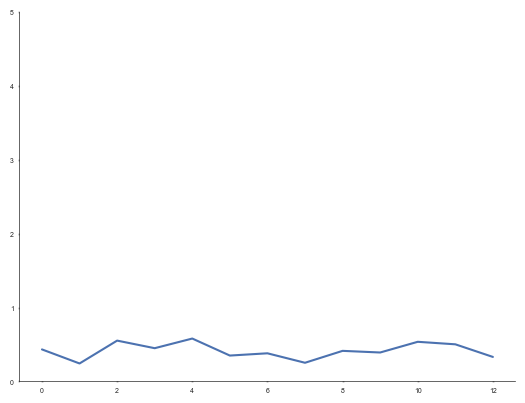

In [ ]:
epoch = 'emergence'
dccs = [np.nanmean(na.avalanche_params[epoch][i].deviation_from_criticality['event_count']['dcc_optimum'].reshape(-1, 1)) for i in range(len(na.avalanche_params[epoch]))]

plt.figure()
plt.plot(dccs)
plt.ylim([0, 5])

In [ ]:
alphas = na.avalanche_params['emergence'][2].power_law_fits['duration'].alphas
Ds = na.avalanche_params['emergence'][25].power_law_fits['duration'].Ds

print(alphas)
print(Ds)

In [ ]:
Taus = na.avalanche_params['emergence'][25].power_law_fits['sum_z'].alphas
Ds = na.avalanche_params['emergence'][25].power_law_fits['sum_z'].Ds
print(Taus)
print(Ds)

In [ ]:
beta_prime = (np.array(alphas) - 1)/(np.array(Taus) - 1)
beta_prime

In [ ]:
(1.99 - 1)/(2.11 - 1)

In [ ]:
na.avalanche_params['emergence'][25].size_duration_beta_coeff

In [ ]:
durations = na.avalanche_params['emergence'][16].duration
sizes = na.avalanche_params['emergence'][16].sum_raw

log_durations = np.log10(durations)
log_sizes = np.log10(sizes)

plt.figure()
plt.scatter(log_durations, log_sizes)

coeffs = np.polyfit(log_durations, log_sizes, deg=1)
beta = coeffs[0]
print(beta)

In [ ]:
epoch_name = 'maintenance'
av_params = na.avalanche_params[epoch_name]
num_segments = len(av_params)

avg_sum_raw = []
avg_sum_z = []
avg_chan_count = []
avg_duration = []
occurrence_freq = []

for seg_idx in range(num_segments):
    ap = av_params[seg_idx]

    avg_duration.append(ap.avg_duration)
    occurrence_freq.append(ap.occurrence_frequency)
    avg_sum_raw.append(ap.avg_sum_raw)
    avg_sum_z.append(ap.avg_sum_z)
    avg_chan_count.append(ap.avg_chan_count)

avg_duration = np.array(avg_duration)
occurrence_freq = np.array(occurrence_freq)
avg_sum_raw = np.array(avg_sum_raw)
avg_sum_z = np.array(avg_sum_z)
avg_chan_count = np.array(avg_chan_count)

In [ ]:
# set_custom_style()
fig, ax = plt.subplots(1,5, figsize=(20, 4))

include_idx = np.where((avg_sum_z > np.nanpercentile(avg_sum_z, 25)) & (avg_sum_z < np.nanpercentile(avg_sum_z, 75)))[0]

ax[0].plot(avg_duration[include_idx])
ax[0].set_title('Average duration')

ax[1].plot(occurrence_freq[include_idx])
ax[1].set_title('Occurrence frequency')

ax[2].plot(avg_sum_z[include_idx])
ax[2].set_title('Average size\n(sum z)')

ax[3].plot(avg_sum_raw[include_idx])
ax[3].set_title('Average size\n(sum raw)')

ax[4].plot(avg_chan_count[include_idx])
ax[4].set_title('Average size\n(chan count)')


## Trash

##### Plot an example period of EEG and show the avalanches detected using Scarpetta method

In [ ]:
from src.eeg_analysis.visualization.plots import plot_eeg

channel_labels = na.channel_names[:16]
sample_rate = na.sampling_frequency
threshold = na.detection_params.threshold

epoch_name = 'emergence'


set_custom_style()
fig, ax = plt.subplots(figsize=(12, 6))

av_idx_to_plot = list(range(20))
# av_with_no_silence_before = np.where(length_silence_before < 1)[0]
# av_with_no_silence_before = np.random.choice(av_with_no_silence_before, size=10, replace=False)

# one_avs_before = av_with_no_silence_before - 1
# av_idx_to_plot = np.sort(np.concatenate((av_with_no_silence_before, one_avs_before)))

start_time_offset = 0

for avalanche_idx in av_idx_to_plot:
    eeg_data = na.avalanches[epoch_name][0]['avalanches']["z_scored"][avalanche_idx]

    silence_before = na.avalanches[epoch_name][0]['silence_before']["z_scored"][avalanche_idx]
    if len(silence_before) > 0:
        start_time_offset = plot_eeg(silence_before, sample_rate, threshold, ax, start_time_offset, channel_labels, True, False)

    start_time_offset = plot_eeg(eeg_data, sample_rate, threshold, ax, start_time_offset, channel_labels, True, True)
    
    silence_after = na.avalanches[epoch_name][0]['silence_after']["z_scored"][avalanche_idx]
    if len(silence_after) > 0 and avalanche_idx == len(av_idx_to_plot)-1:
        start_time_offset = plot_eeg(silence_after, sample_rate, threshold, ax, start_time_offset, channel_labels, True, False)

main_dir = f'D:/capachinos' 
filename = 'avalanches_beggs_20_IEI.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Plotting the distribution of the parameters for each segment

In [ ]:
## The Following cell needs corrections
from math import ceil, log10

from matplotlib.gridspec import GridSpec
# Set figure styles
set_custom_style()

epochs = ['emergence']  # 'preop_rest', 'pre_drug_infusion', 'pacu_rest'
params = ['duration', 'sum_z', 'chan_count', 'event_count', 'region_count']  #
segment_duration = na.segment_duration

parameters_value_range = {
    'duration': (0.001, 0.1),
    'sum_raw': (5e-5, 1e-2),
    'sum_z': (2, 70),
    'chan_count': (1, 16),  # treated differently
    'event_count': (1, 16),
    'region_count': (1, 5)
}

num_bins = {
    'duration': 15,
    'sum_raw': 15,
    'sum_z': 15,
    'chan_count': 10,  
    'event_count': 10,
    'region_count': 5
}

log_y_axis = {
    'duration': True,
    'sum_raw': True,
    'sum_z': True,
    'chan_count': True,
    'event_count': True,
    'region_count': False
}  # Flag to toggle log or linear y-axis

# Set up the figure and GridSpec layout
fig_width, fig_height = 10, 10
fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])
num_params = len(params)

# Define GridSpec: each parameter gets its own column
gridspec_cols = num_params  
gs = GridSpec(nrows=1, ncols=gridspec_cols, figure=fig, wspace=0.5, hspace=0.5)
# Use a colormap to differentiate epochs
colors = plt.cm.viridis(np.linspace(0, 1, len(epochs)))

# Loop over parameters and plot data
for idx, param in enumerate(params):
    print(param)
    ax = fig.add_subplot(gs[0, idx])  # Use GridSpec for positioning

    concatenated_data = []
    epoch_start_indices = []

    for epoch_idx, epoch in enumerate(epochs):
        segment_data = [na.avalanche_params[epoch][seg_idx].get(param) for seg_idx in range(len(na.avalanche_params[epoch]))]
        concatenated_data.extend(segment_data)

        data_range = [np.min(np.concatenate(concatenated_data)), np.max(np.concatenate(concatenated_data))]

        epoch_start_indices.append(len(concatenated_data))
        
        # Calculate the window_centers for time axis
        time_points = np.arange(len(segment_data)) * segment_duration
        if epoch_idx > 0:
            time_points += epoch_start_indices[epoch_idx - 1] * segment_duration
        
        for i, segment in enumerate(segment_data):
            
            if segment is None or len(segment) == 0:
                continue

            # if param=='duration':
            #     segment = [0.001 if x == 0 else x for x in segment]

            # fit = powerlaw.Fit(segment, verbose=False)
            # if log_y_axis[param]:
            #     fit.plot_pdf(ax=ax, original_data=True)
            # else:
            #     fit.plot_pdf(ax=ax, linear_bins=True, original_data=True)
    
            # Determine the center of the segment for y-axis placement
            segment_center = time_points[i] + segment_duration / 2
            # xmin, xmax = parameters_value_range.get(param, (min(segment), max(segment)))
            xmin, xmax = data_range[0], data_range[1]
            if param=='duration':
                xmin = np.max([xmin, 0.001])

            if  log_y_axis[param]:
                log_min_size = log10(xmin)
                log_max_size = log10(xmax)
                
                number_of_bins = ceil((log_max_size-log_min_size)*10)
                bins = np.logspace(log_min_size, log_max_size, number_of_bins)
                # bins[:-1] = np.floor(bins[:-1])
                # bins[-1] = ceil(bins[-1])
                # bins = np.unique(bins)
            else:
                bins = np.linspace(xmin, xmax, num_bins[param])

            # Plot each list in segment_data as a histogram on the horizontal axis

            hist, bin_edges = np.histogram(segment, bins=bins, density=False)
            hist = hist*segment_duration/np.max(hist)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            ax.plot(bin_centers, hist + segment_center, alpha=0.8, label=epoch if i == 0 else "", color=colors[epoch_idx])
            ax.plot(bin_centers, [segment_center]*len(bin_centers), alpha=0.5, linestyle='--', color='gray')
            # except:
            #     print(f'did not work for segment {i} of param={param}')


    # Set y-axis to reflect centers of the segments
    max_time = max(time_points) + segment_duration
    center_positions = np.arange(segment_duration / 2, max_time, segment_duration)
    ax.set_yticks(center_positions)
    ax.set_yticklabels([str(int(pos)) for pos in center_positions], rotation=0)
    
    # Draw horizontal lines to indicate the end of each epoch's data
    for start_index in epoch_start_indices[:-1]:  # Skip the final epoch index
        ax.axhline(start_index * segment_duration, linestyle='--', color='grey')
    
    if log_y_axis[param]:
        ax.set_xscale('log')

    ax.set_xlim(data_range)

    ax.tick_params(axis='both', which='major', labelsize=10, length=2, width=0.5, pad=1)
    ax.set_xlabel(param, fontsize=12)

    if idx == 0:
        ax.set_ylabel('Time (s)', fontsize=12)
    ax.legend()

fig.suptitle('Avalanche Parameters Across Emergence', fontsize=14)
fig.tight_layout()
plt.show()